In [2]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client, progress
import dask.array as da
import numpy as np
import pandas as pd
import zarr
import allel
import sys
import ag3
import psutil
from humanize import naturalsize
import numba

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
n_workers = 20

In [4]:
# cluster setup
cluster = KubeCluster()
cluster.scale_up(n_workers)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.33.122.64:36773
distributed.scheduler - INFO -   dashboard at:                     :8787


In [5]:
# dask client setup
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-0a6f0624-1eb9-11eb-94fb-1ef89187f1b0
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.122.64:36773 Dashboard: /user/nicholasharding/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
# grab data from release
v3 = ag3.release_data()

In [7]:
sample_set = "AG1000G-TZ"

In [8]:
meta = v3.load_sample_set_metadata(sample_set)

distributed.scheduler - INFO - Register tcp://10.32.175.4:44487
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.175.4:44487
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.161.4:44873
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.161.4:44873
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.170.4:44129
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.170.4:44129
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.162.4:42451
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.162.4:42451
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.169.4:32913
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.169.4:32913
distributed.c

In [9]:
xtab = pd.crosstab(meta.location, meta.species_gambcolu_arabiensis)
xtab

species_gambcolu_arabiensis,arabiensis,gamb_colu
location,,
Moshi,40,0
Muheza,1,42
Muleba,137,33
Tarime,47,0


In [10]:
include_locs = (xtab > 10).all(axis=1)
include_locs

location
Moshi     False
Muheza    False
Muleba     True
Tarime    False
dtype: bool

In [11]:
def equally_accessible_chunks(is_accessible, window_size=50_000):
    
    if not isinstance(is_accessible, np.ndarray):
        is_accessible = np.array(is_accessible)
    
    cumsum = np.cumsum(is_accessible)
    z = ((cumsum % window_size) == 0) & (cumsum >= window_size)

    # only select cells that are multiples of window size **and** are not followed by another cell that contains the window size.
    same_follows = np.diff(z.astype(int), append=0) == 0

    ix = np.where(z & ~same_follows)[0] + 1

    _chunks = np.diff(ix, prepend=0)
    
    return tuple(_chunks), _chunks.sum()

In [35]:
@numba.njit
def dist_block(a, masked, ix, jx):
    
    """
    a: n_alts array
    masked: 1D mask of the same size in 0 axis.
    ix: indicies of the first population
    jx: indicies of the second population
    
    """
    
    diff_sum = np.zeros((ix.shape[0], jx.shape[0]), dtype=np.int32)
    diff_denom = np.zeros((ix.shape[0], jx.shape[0]), dtype=np.int32)
    
    for x in range(a.shape[0]):
        
        i_counter = 0

        # if site filtered by mask
        if not masked[x]:
            continue
    
        for i in ix:
            
            # if i is missing, do not bother to loop through j.
            if a[x, i] < 0:
                continue
            
            j_counter = 0

            for j in jx:

                # if j is missing continue with next j
                if a[x, j] < 0:
                    continue

                else:
                    diff_sum[i_counter, j_counter] += abs(a[x, i] - a[x, j])
                    diff_denom[i_counter, j_counter] += 2

                j_counter += 1

            i_counter += 1
            
    out = diff_sum / diff_denom

    return np.expand_dims(out, axis=0)

In [21]:
chromosomes = ["2L", "2R", "3L", "3R", "X"]

In [92]:
pd_dict = {}
pos_dict = {}
genome = {}

# look only at locations where we have gamb_xand arab.
for location in meta.location.unique():
    if not include_locs.loc[location]:
        continue
    else:
        print(location)
        
    ix_arab = np.where((meta.location == location) & (meta.species_gambcolu_arabiensis == "arabiensis").values)[0]
    ix_gambcolu = np.where((meta.location == location) & (meta.species_gambcolu_arabiensis == "gamb_colu").values)[0]
    
    pd_dict[location] = {}
    
    for chrom in chromosomes:
        
        g = v3.load_sample_set_calldata(chrom, sample_set)

        mask = v3.load_mask(chrom, 'gamb_colu_arab')

        # this doesn't handle multiallelic sites...
        y = allel.GenotypeDaskArray(g).to_n_alt(fill=-1)

        chunk_sizes, end = equally_accessible_chunks(mask)

        # rechunk n_alts to ensure correct size
        yrc = y[:end].rechunk((chunk_sizes, y.shape[1]))

        # reshape and rechunk mask
        maskrc = mask[:end].reshape((-1, 1)).rechunk((chunk_sizes, (1,)))
        
        q = da.map_blocks(
            dist_block, yrc, maskrc, dtype=np.float32, 
            chunks=(1, ix_arab.shape[0], ix_gambcolu.shape[0]), 
            drop_axis=(1,), new_axis=[1, 2], ix=ix_arab, jx=ix_gambcolu)
        
        pairwise_diff = q.compute()
        
        posi = v3.load_variants(chrom)
        
        genome[chrom] = int(posi[-1].compute())

        midpoints = da.map_blocks(
            lambda y: np.median(y).reshape((1, 1)), 
            posi[:end].reshape((-1, 1)).rechunk((chunk_sizes, 1)),
            chunks=(1, 1)).compute().squeeze()
        
        pos_dict[chrom] = midpoints
        pd_dict[location][chrom] = np.percentile(pairwise_diff, (0, 1, 5, 25, 50, 75, 95, 99, 100), axis=(1, 2))

Muleba


In [93]:
from ag3 import GenomeFigure

In [107]:
def draw_introgression_relative(chrom, ax, location):

    minimum = pd_dict[location][chrom][0]
    median = pd_dict[location][chrom][4]
    
    pos = pos_dict[chrom]
    
    ax.plot(pos, np.log2(median / minimum))
    ax.grid(True)
    ax.set_ylim(0, 3)

In [103]:
def draw_introgression(chrom, ax, location):

    minimum = pd_dict[location][chrom][0]
    median = pd_dict[location][chrom][4]
    
    pos = pos_dict[chrom]
    
    ax.plot(pos, minimum)
    ax.plot(pos, median)
    ax.set_ylim(0, .02)

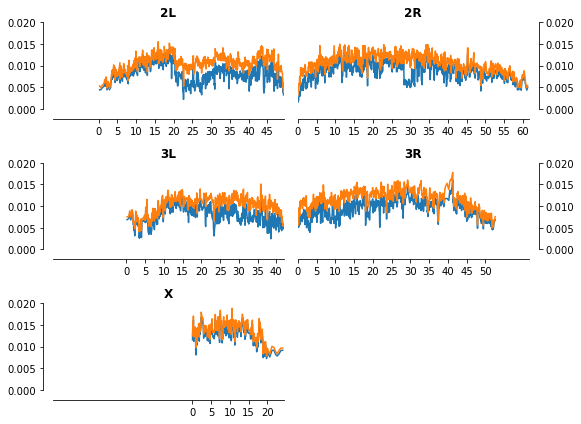

In [98]:
f = GenomeFigure(genome, chromosomes=genome.keys(), figsize=(8, 6))

f.apply(draw_introgression, location="Muleba")

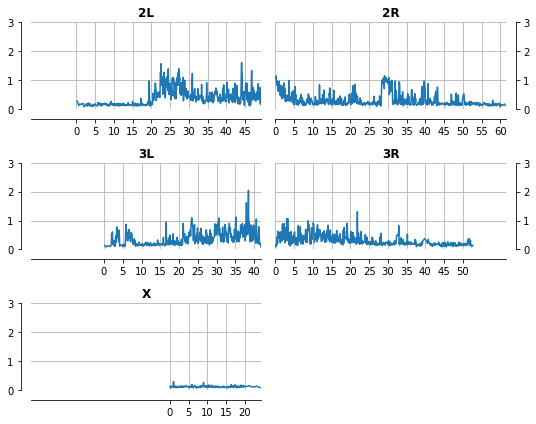

In [108]:
f = GenomeFigure(genome, chromosomes=genome.keys(), figsize=(8, 6))

f.apply(draw_introgression_relative, location="Muleba")